# DCM3 Quantum Challenge

In [1]:
try:
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit_superstaq as qss

try:
    import qcaas_client.client
    import scc
except ImportError:
    print("Installing oqc-qcaas-client...")
    %pip install --quiet 'oqc-qcaas-client'
    print("Installed oqc-qcaas-client.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit_superstaq as qss

import os
import qiskit
import numpy as np

%pip install --quiet 'qiskit-aer'
from qiskit_aer.library import save_statevector

In this notebook, we will explore some of the possible applications of quantum computing to the field of communications. 
- The first application will show how quantum information can be transmitted using quantum channels in what is known as quantum teleportation.
- The second will introduce a way to perform fingerprinting using quantum states.

<b><font color="Red">Wherever you should insert code, you will see a line `# code goes here`.</font></b>

### <b><font color="Red">HELPER FUNCTIONS: DO NOT MODIFY</font></b>

These functions are used for visualisation and circuit submission -- do not modify them. **Don't forget to execute this cell!**

In [45]:
## HELPER FUNCTIONS
from IPython.display import display
import matplotlib.pyplot as plt

remove_barriers = qiskit.transpiler.passes.RemoveBarriers()

def visualise_bloch_sphere(qc):
    sv = qiskit.quantum_info.Statevector(qc)
    display(qiskit.visualization.plot_bloch_multivector(sv))

def show_bobs_qubit(qc):
    simulator = qiskit.BasicAer.get_backend("statevector_simulator")
    circ = qiskit.transpile(qc, simulator)
    sv = simulator.run(circ).result().get_statevector()
    bobs = sv[sv!=0]
    display(qiskit.visualization.plot_bloch_multivector(bobs))

def draw_circuits(circuits, figsize_scale=2.5, title="circuits"):
    nrows = np.floor(np.sqrt(len(circuits))).astype(int)
    ncols = np.ceil(len(circuits) / nrows).astype(int)
    figure, axes_array = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(figsize_scale * ncols, figsize_scale * nrows),
    )
    plt.subplots_adjust(wspace=0, hspace=0)
    # figure.suptitle(title)
    # figure.patch.set_linewidth(10)
    # figure.patch.set_edgecolor("k")
    if nrows * ncols > 1:
        axes_array = axes_array.flatten()
    else:
        axes_array = [axes_array]
    for circuit, axes in zip(circuits, axes_array):
        axes.axis("off")
        circuit.draw("mpl", style={"name": "clifford"}, ax=axes)

def authenticate_oqc_qcaas():
    oqc_client = qcaas_client.client.OQCClient(
        url="https://lhr3.qcaas.oqc.app/",  # qcaas domain URL
        email="david.owusu-antwi@infleqtion.com",
        password=os.getenv("OQC_CLIENT_PASSWORD"),
    )
    oqc_client.authenticate()
    return oqc_client

def toshiko_submit(circuits, wait_for_submit=True):
    compiler_config = scc.compiler.config.CompilerConfig(
        repeats=1000,
        results_format= scc.compiler.config.QuantumResultsFormat().binary_count(),
    )

    tasks = []
    for circuit in circuits:
        task = qcaas_client.client.QPUTask(
            program=remove_barriers(circuit).qasm(),
            config=compiler_config,
        )
        tasks.append(task)

    if wait_for_submit:    
        results = oqc_client.execute_tasks(tasks)
        logs = [oqc_client.get_task_timings(result.id) for result in results]
        print(logs)
        return [result.result["c"] for result in results], logs

    scheduled_tasks = oqc_client.schedule_tasks(tasks)
    task_ids = [task.task_id for task in scheduled_tasks]
    for task_id in task_ids:
        print(f"task id: {task_id}")
        print(f"task log: {oqc_client.get_task_timings(task_id)}")
        print(f"status: {oqc_client.get_task_status(task_id)}")
    return task_ids

def get_results(task_ids):
    """Use this to retrieve results from task IDs."""
    return [oqc_client.get_task_results(task_id).result["c"] for task_id in task_ids]

def plot_fidelities_heatmap(distributions):
    results = [counts["0"] / 1000 for counts in distributions]

    # Create a 6x6 array of zeros
    fidelities = np.ones((6, 6)) * 1 / 2
    
    # Fill the upper triangle
    fidelities[np.triu_indices(6, 1)] = list(map(lambda x: x / 2, results))
    
    # Copy the upper triangle to the lower triangle
    fidelities += fidelities.T

    plt.figure(dpi=150)
    plt.imshow(fidelities)
    plt.colorbar()

oqc_client = authenticate_oqc_qcaas()

# 1) Quantum teleportation

The **quantum teleportation** communication protocol is a good example of how superposition and entanglement can be leveraged to achieve something that cannot be done classically.

- Suppose that the usual suspect, **Alice**, wants to send information to the other usual suspect, **Bob**, while the two of them are far apart. More precisely, Alice wants to send the quantum state:

$$|\psi\rangle = c_0|0\rangle + c_1|1\rangle$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Where $c_0$ and $c_1$ are complex numbers.

- Suppose further that before separating, they prepare on a pair of qubits the entangled state:

$$|q\rangle_A|q\rangle_B = \frac{|0\rangle_A|0\rangle_B + |1\rangle_A|1\rangle_B}{\sqrt{2}}$$

and each takes one qubit. A measurement on one qubit will collapse its state to the measured state. Because the two qubits are entangled, a measurement on either qubit will also collapse the other qubit's state. This shared information is key to the quantum teleportation protocol used to transmit information from Alice to Bob.

## Preparing the entangled qubits
First, we prepare the entagled qubits that Alice and Bob will share, using the following circuit:
<center>
    <img src="resources/teleport1.png"/>
</center>

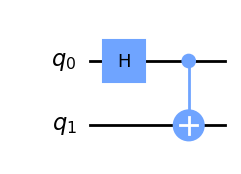

In [3]:
ent = qiskit.QuantumCircuit(2)
# code goes here
ent.h(0)
ent.cx(0, 1)
# code goes here
ent.draw("mpl", style="clifford")

This circuit will prepare the qubits $|q_0q_1\rangle$ from the state $|00\rangle$ to the state:
$$
    \frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle
$$
Which is an entangled state.

The next line of code will abstract this circuit into a quantum gate.

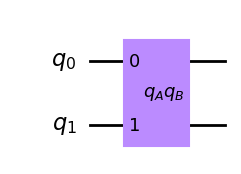

In [4]:
gate_ent = ent.to_gate(label="$q_Aq_B$")

# Visualise above circuit abstracted into a single gate:
qc = qiskit.QuantumCircuit(2)
qc.append(gate_ent, (0, 1))
qc.draw("mpl", style="clifford")

## Preparing the data qubit
Now Alice will prepare the data qubit that she wants to send to Bob. For an axis $p$, the gate $R_p(2\theta) = R_p(2f\pi)$ will rotate the qubit state by $f$ of a full turn about axis $p$.

E.g., $R_x(2\cdot \frac{1}{4}\cdot\pi)$ applied to a qubit $q_0$ will rotate its state by a quarter turn around the $x$-axis.

In the following circuit:
- `rx(2 * fx * np.pi, 0)` will rotate the qubit a `fx` turn around the x-axis
- `ry(2 * fy * np.pi, 0)` will rotate the qubit a `fy` turn around the y-axis
- `rz(2 * fz * np.pi, 0)` will rotate the qubit a `fz` turn around the z-axis

The aforementioned axes are the ones shown in the Bloch sphere. 

You can customise this data by changing the values of `fx`, `fy` and `fz` (with values between 0 and 1) and see the results of these changes on the qubit state's location on the Bloch sphere. Qubits are initialised at 0 (the north pole of the Bloch sphere).

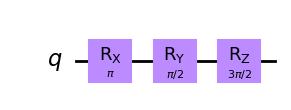

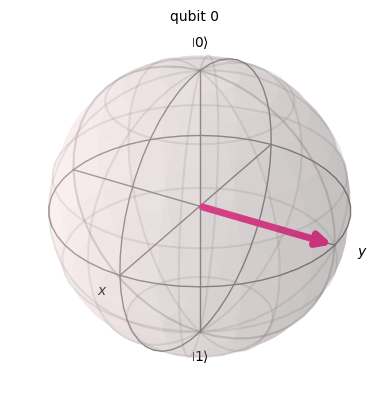

In [6]:
fx = 0.5 # Put your own value between 0 and 1
fy = 0.25 # Put your own value between 0 and 1
fz = 0.75 # Put your own value between 0 and 1

psi = qiskit.QuantumCircuit(1)
psi.rx(2 * fx * np.pi, qubit=0)
psi.ry(2 * fy * np.pi, qubit=0)
psi.rz(2 * fz * np.pi, qubit=0)
display(psi.draw("mpl", style="clifford"))

visualise_bloch_sphere(psi)

Here again we abstract this data qubit preparation into a quantum gate.

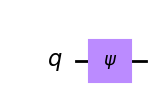

In [7]:
gate_psi = psi.to_gate(label="$\psi$")

# Visualise above circuit abstracted into a single gate:
qc = qiskit.QuantumCircuit(1)
qc.append(gate_psi, (0,))
qc.draw("mpl", style="clifford")

## Preparing the teleportation
We now start the teleportation process. To do so, we need a circuit with 3 qubits:
- one qubit for Alice's data,
- two qubits for the entangled two-qubit state that Alice and Bob share.*

*While we will represent them as close to each other, they can be as far apart as needed and this protocol will still work. In fact, the record for the longest quantum teleportation is 143km, set in [2012](https://www.esa.int/Enabling_Support/Space_Engineering_Technology/ESA_observatory_breaks_world_quantum_teleportation_record#:~:text=An%20international%20research%20team%20using%20ESA%E2%80%99s%20Optical%20Ground,light%20particle%20across%20143%20km%20of%20open%20air.).

The teleportation protocol also requires 2 classical bits.



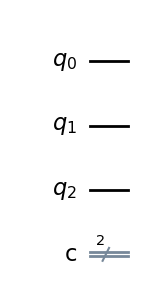

In [8]:
teleportation = qiskit.QuantumCircuit(3, 2)

teleportation.draw("mpl", style="clifford")

Now Alice and Bob prepare the entangled qubits and each take one qubit:

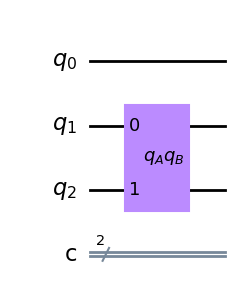

In [9]:
teleportation.append(gate_ent, [1, 2])

teleportation.draw("mpl", style="clifford")

Then Alice prepares the qubit that she wishes to send to Bob:

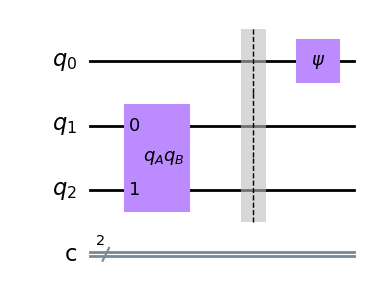

In [10]:
teleportation.barrier()
teleportation.append(gate_psi, [0])

teleportation.draw("mpl", style="clifford")

Now for the teleportation protocol, Alice entangles her data qubit with her qubit from the entangled pair. By doing so, Bob's qubit is also entangled to Alice's data qubit (i.e., a three-way entanglement) resulting in the following circuit:
<center><img src="resources/teleport20.png"/></center>

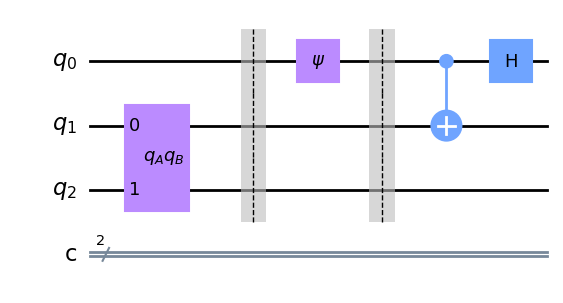

In [11]:
teleportation.barrier()
# code goes here
teleportation.cx(0, 1)
teleportation.h(0)
# code goes here
teleportation.draw("mpl", style="clifford")

At this stage, the system of three qubits $\lvert q_0q_1q_2\rangle$ is in the entangled state
$$
        \lvert q_0q_1q_2\rangle = \frac{1}{2} \left(|00\rangle|\psi_{00}\rangle+|01\rangle|\psi_{01}\rangle+|10\rangle|\psi_{10}\rangle+|11\rangle|\psi_{11}\rangle\right)
$$
so Alices's two qubits are in a superposition of the states $|00\rangle$, $|01\rangle$, $|10\rangle$ and $|11\rangle$ while Bob's qubit is in a superposition of the following states:
$$
\begin{align*}
    |\psi_{00}\rangle &= c_0|0\rangle + c_1|1\rangle = |\psi\rangle\\
    |\psi_{01}\rangle &= c_0|1\rangle + c_1|0\rangle\\
    |\psi_{10}\rangle &= c_0|0\rangle - c_1|1\rangle\\
    |\psi_{11}\rangle &= c_0|1\rangle - c_1|0\rangle\\
\end{align*}
$$
Comparing to Alice's original state $|\psi\rangle = c_0|0\rangle + c_1|1\rangle$ you can see that Bob's qubit is in a superposition of four possible variants of Alice's original qubit state. From these variants, it is possible to retrieve her original qubit state:
- By doing nothing to the state $|\psi_{00}\rangle$
- By applying a $\mathbf{X}$ gate to the state $|\psi_{01}\rangle$
- By applying a $\mathbf{Z}$ gate to the state $|\psi_{10}\rangle$
- By applying a $\mathbf{X}$ gate followed by $\mathbf{Z}$ gate to the state $|\psi_{10}\rangle$

Now suppose that Alice measures her two qubits. Because of entanglement, we have that:
- If she measures $00$, then Bob's qubit will collapse to the state $|\psi_{00}\rangle$
- If she measures $01$, then Bob's qubit will collapse to the state $|\psi_{01}\rangle$
- If she measures $10$, then Bob's qubit will collapse to the state $|\psi_{10}\rangle$
- If she measures $11$, then Bob's qubit will collapse to the state $|\psi_{11}\rangle$

Hence, Bob can retrieve Alice's data if she measures her two qubits and sends him the result of the measurements.

### Retrieving Alice's state

As explained previously, Alice performs a measurement on the 2 qubits that she possesses and sends the result to Bob via a classical channel. Bob uses this result to determine which gates to apply.

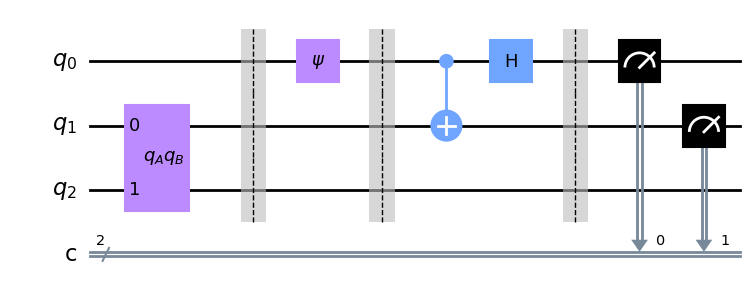

In [12]:
teleportation.barrier()
teleportation.measure([0, 1], [0, 1])
teleportation.draw("mpl", style="clifford")

Alice has in her possession qubits $q_0$ and $q_1$, her data qubit and her half of the original entangled pair shared with Bob, respectively.
- if Alice measures $1$ on $q_0$, then Bob has to apply a $\mathbf{Z}$ gate to his qubit $q_2$
- if Alice measures $1$ on $q_1$, then Bob has to apply a $\mathbf{X}$ gate to his qubit $q_2$


These conditional gates are performed with the `c_if` method where the first argument is the index of a classical bit (storing the measurement outcome) that gate application is conditioned on and the second argument is the value that triggers gate application.

E.g., `teleportation.z(0).c_if(classical=0, val=1)` applies a Z-gate on qubit 0 if classical bit `classical=0` has a readout of `val=1`.

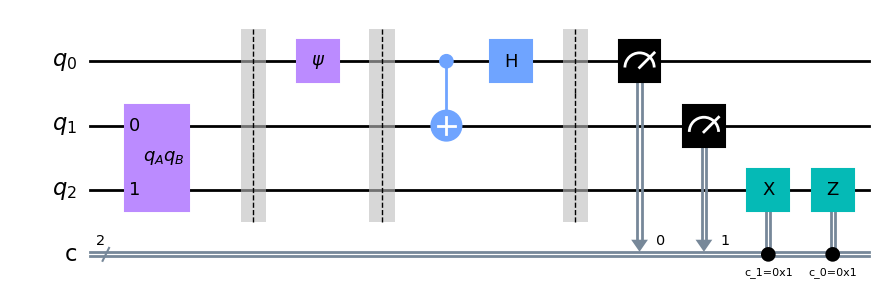

In [13]:
teleportation.x(2).c_if(classical=1, val=1)
teleportation.z(2).c_if(classical=0, val=1)

teleportation.draw("mpl", style="clifford")

In the end, we can verify that Bob's qubit is indeed similar to the one Alice wanted to share with him. (Here we use an internal simulator to run the quantum teleportation circuit.)

This is what Bob now has:

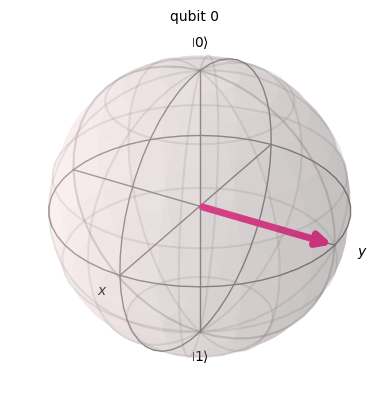

In [14]:
show_bobs_qubit(teleportation)

Compare with the state Alice originally sent:

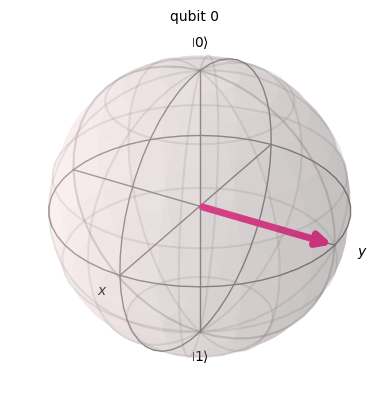

In [16]:
visualise_bloch_sphere(psi)

You can check that this protocol works for any state by running it again with different values for `fx`, `fy` and `fz`.

So thanks to the quantum teleportation protocol, Alice managed to send a quantum state to Bob from afar. If Alice encodes some information into a quantum state, then this protocol allows her to securely transmit it to Bob.

One limitation of this protocol is its reliance on classical channels for Alice to communicate to Bob the results of her measurements. 

In the event that a bad actor eavesdrops on this classical channel, they can know the results of Alice's measurement. Although they can corrupt the data transmission by changing the content of Alice's message (in which case Bob cannot retrieve the correct state), without any knowledge of the original state, they cannot infer anything from the measurement results. [Quantum key distribution](https://en.wikipedia.org/wiki/Quantum_key_distribution) is one proposed protocol for replacing the classical channel with a more secure quantum channel.

In the following section, we will explore one way for Alice to encode information in a qubit's state: **quantum fingerprinting**.

# 2) Quantum Fingerprinting

## Fingerprinting

**Fingerprinting** is a procedure that maps a piece of data (e.g., a file) to a much smaller identifier. Similar to human fingerprints, this identifier should be unique to the file it is assigned to, so that two fingerprints differ if and only if the two files differ.

- This procedure is particularly useful in the context of distributed databases where it allows comparing two copies of a file (i.e., synchronisation). Instead of transmitting large files and comparing them directly, one can instead transmit and compare the much smaller fingerprints and to validate the identity of a copy.

- A common classical method for fingerprinting is through using a *hash function*. Although efficient, it is possible for two different files to have the same hash, an event known as collision. E.g., the possibility of collisions leave hash functions vulnerable to [birthday attacks](https://en.wikipedia.org/wiki/Birthday_attack).

In the classical case, suppose we want to reduce the fingerprint size to the absolute minimum: a single bit. Such a protocol can only fingerprint 2 files (there are only two possible fingerprints, 0 and 1).

Now suppose that we have access to a qubit -- how many files can be fingerprinted with this protocol?

In theory, an infinity of files could be fingerprinted by a single qubit. To do so, it suffices to map each file to a different possible qubit state. If we consider the Bloch sphere representation of the qubit, this would amount to placing different files at different locations on the surface of the sphere.

But the more files are placed on the sphere, the closer they will be to each other. That, taken with the fact we can only estimate the state of a qubit through measurement, shows that we can only fingerprint a limited number of files with a single qubit.

Suppose we have a suitable quantum fingerprinting protocol using a single qubit. Recalling the quantum teleportation protocol explained in section 1, Alice can send the fingerprint for a file of interest stored in a database that is shared with Bob so that he can also look up the file that Alice wants to share with him. This exchange would then be secured from interception (but not from corruption).

## Quantum fingerprinting

Consider the 6 states represented in the following Bloch spheres:

| **State 1** | **State 2** | **State 3** |
| :---: | :---: | :---: |
| <div><img src="resources/state_1.png" width="300"/></div> | <div><img src="resources/state_2.png" width="300"/></div> | <div><img src="resources/state_3.png" width="300"/></div> |

| **State 4** | **State 5** | **State 6** |
| :---: | :---: | :---: |
| <div><img src="resources/state_4.png" width="300"/></div> | <div><img src="resources/state_5.png" width="300"/></div> | <div><img src="resources/state_6.png" width="300"/></div> |

### <b><font color="red">Your task is to come up with quantum circuits generating these 6 states.</font></b>

These states are of interest as they are "maximally distinguishable" in the sense that they can be distinguished easily with relatively few measurements.

Here we give some of the most commonly used quantum gates with their matrix representation: 
$$
    \mathbf{I} = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \ \mathbf{X} = \begin{bmatrix}0 & 1\\1 & 0\end{bmatrix}, \ \mathbf{Y} = \begin{bmatrix}0 & -i\\i & 0\end{bmatrix}, \ \mathbf{Z} = \begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}, \ \mathbf{H} = \begin{bmatrix}\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}}\end{bmatrix} \text{ and } \ \mathbf{S} = \begin{bmatrix}1 & 0\\0 & i\end{bmatrix}
$$

In principle, one way you might proceed is to use these matrix representations to try and determine a sequence of gates that reproduces the deisred state. You may also work by trial and error.

The Bloch sphere visualisations will help you match the states you obtain with the expected states.

You may find some of the following gate operations handy:

| Gate Operation | Gate Name | Symbol |
| --- | --- | --- |
| `circuit.h(qID)` | Hadamard | |
| `circuit.x(qID)` | Pauli X (Not) | |
| `circuit.y(qID)` | Pauli Y | |
| `circuit.z(qID)` | Pauli Z | |
| `circuit.s(qID)` | S (Phase) |  |
| `circuit.t(qID)` | T | |
| `circuit.id(qID)` | Identity | |
| `circuit.cx(cID, tID)` | Controlled-X (Controlled-Not) | |
| `circuit.cz(cID, tID)` | Controlled-Z (ZZ Interaction) | |

**State 1**

In [17]:
qc1 = qiskit.QuantumCircuit(1, name="qc1")
# code goes here

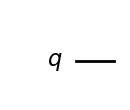

In [18]:
qc1.draw("mpl", style="clifford")

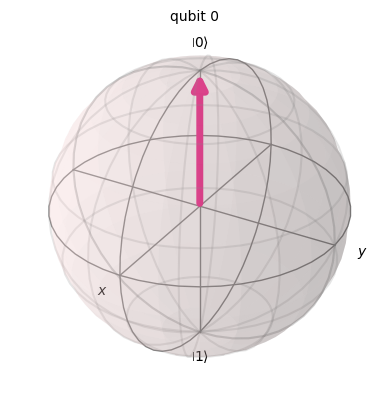

In [19]:
visualise_bloch_sphere(qc1)

**State 2**

In [20]:
qc2 = qiskit.QuantumCircuit(1, name="qc2")
# code goes here
qc2.x(0)

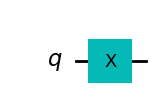

In [21]:
qc2.draw("mpl", style="clifford")

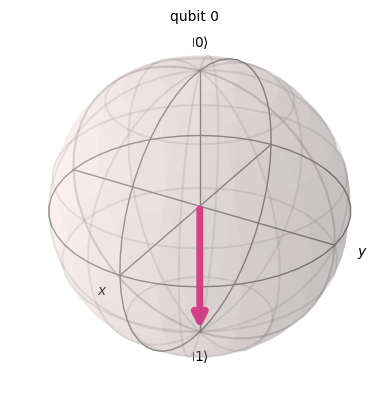

In [22]:
visualise_bloch_sphere(qc2)

**State 3**

In [23]:
qc3 = qiskit.QuantumCircuit(1, name="qc3")
# code goes here
qc3.h(0)

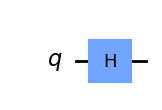

In [24]:
qc3.draw("mpl", style="clifford")

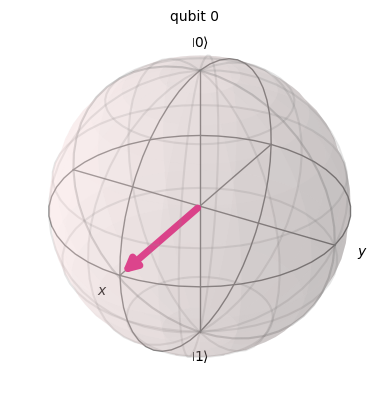

In [25]:
visualise_bloch_sphere(qc3)

**State 4**

In [26]:
qc4 = qiskit.QuantumCircuit(1, name="qc4")
# code goes here
qc4.h(0)
qc4.z(0)

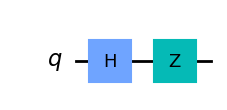

In [27]:
qc4.draw("mpl", style="clifford")

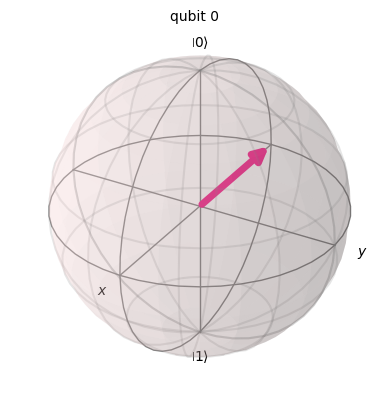

In [28]:
visualise_bloch_sphere(qc4)

**State 5**

In [29]:
qc5 = qiskit.QuantumCircuit(1, name="qc5")
# code goes here
qc5.h(0)
qc5.s(0)

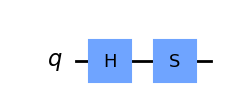

In [30]:
qc5.draw("mpl", style="clifford")

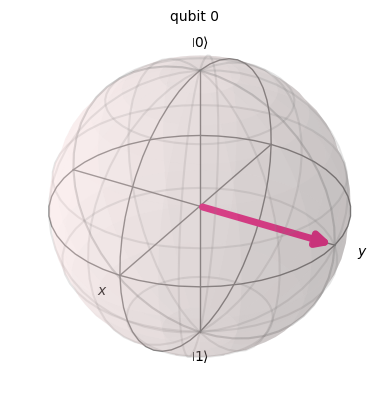

In [31]:
visualise_bloch_sphere(qc5)

**State 6**

In [32]:
qc6 = qiskit.QuantumCircuit(1, name="qc6")
# code goes here
qc6.h(0)
qc6.s(0)
qc6.z(0)

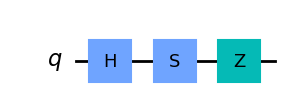

In [33]:
qc6.draw("mpl", style="clifford")

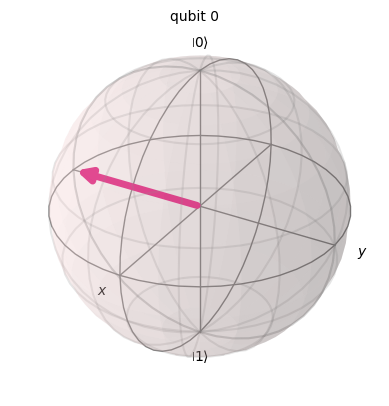

In [34]:
visualise_bloch_sphere(qc6)

## SWAP test

Now that you have prepared these 6 states, we need a way of comparing them. 

One way is to perform measurements. E.g., if one qubit is in State 1 and the other in State 2, then we can easily distinguish them with measurements:

| **State 1** | **State 2** |
| :---: | :---: |
| <div><img src="resources/state_1.png" width="150"/></div> | <div><img src="resources/state_2.png" width="150"/></div> |

Measuring the first state will always return 0 while measuring the second state will always return 1.

But what if one qubit is in State 3 and the other in State 4?

| **State 3** | **State 4** |
| :---: | :---: |
| <div><img src="resources/state_3.png" width="150"/></div> | <div><img src="resources/state_4.png" width="150"/></div> |

You can verify that measurements of a qubit in either state will return 0 with probability $\frac{1}{2}$ and 1 with probability $\frac{1}{2}$. Simply measuring is thus not enough to compare two qubits.

To remedy this, we can use what is known as a **swap test**, as performed by the following circuit to compare qubits $q_1$ and $q_2$:

<center><div><img src="resources/swap.png" width=300/></div></center>

Here the gates marked $\phi$ and $\psi$ prepare the second and third qubit in the states $|\phi\rangle$ and $|\psi\rangle$ respectively. In our case, $|\phi\rangle$ and $|\psi\rangle$ will be any pair of the 6 states that you prepared with your circuits.

One gate that you may be encountering for the first time is the **controlled swap** gate, here located inbetween the two Hadamard gates:

| CSWAP | SWAP |
| --- | --- |
| <div><img src="resources/cswap.png" width="100"/></div> | <div><img src="resources/swap_gate.png" width="100"/></div> |

As it name suggests, the **swap** gate swaps the values of 2 qubits, i.e.:

$$|\phi\rangle|\psi\rangle \overset{\text{SWAP}}{\Rightarrow} |\psi\rangle|\phi\rangle$$

Hence the controlled swap gate will perform this operation on the last two qubits when the first qubit is in state $|1\rangle$.

At the end of this circuit, the probability for the measurement to return 0 is given by

$$\Pr(\lvert q_0\rangle = \lvert 0\rangle) = \frac{1 + |\langle \phi|\psi\rangle|^2}{2}$$

where the term $|\langle \phi|\psi\rangle|^2$ is referred to as the *fidelity* between the two states $\phi$ and $\psi$. The fidelity essentially measures how close the two states are to each other:
- If the states are identical (i.e., at the same location on the Bloch sphere), the fidelity is 1
- If they are maximally distinct (i.e., diametrically opposed on the Bloch sphere), the fidelity is 0
- In all other cases, the fidelity is strictly between 0 and 1

In a nutshell: if the compared states are **identical** then measurement will **always output 0**; if they are **not identical**, measurement will **output 1** with some nonzero probability (e.g., probability of 1/2 for maximally distinguishable states). We have implemented the swap test for you -- it will be used to generate swap test circuits comparing the circuits you've defined above.

In [52]:
## HELPER FUNCTION -- DO NOT MODIFY
def swap_test(circuit1, circuit2):
    """Get a Swap Test circuit.

    Measuring the ancilla qubit returns 0 with 100% probability if the states
    are identical, and 0-1 with 50-50% probability if the states are orthogonal.
    """
    swap_test = qiskit.QuantumCircuit(3, 1)
    swap_test.barrier()
    swap_test.h(0)
    swap_test.cswap(0, 1, 2)
    swap_test.h(0)
    swap_test.barrier()
    swap_test.measure([0], [0]) 

    swap_test.compose(qc_a, qubits=[1], front=True, inplace=True)
    swap_test.compose(qc_b, qubits=[2], front=True, inplace=True)

    return swap_test

**In the next section, you will run these circuits on a real quantum computer.**

# 3) Running on a Real Quantum Computer

The quantum computer you will use is the latest from **Oxford Quantum Circuits (OQC)**: Toshiko.

| <a href="https://oxfordquantumcircuits.com/technology/toshiko"><font size=5>**Oxford Quantum Circuits Toshiko**</font></a>|
| --- |
| <center><img src="resources/OQC_toshiko.png" width="200"/></center> |

OQC's quantum computers are based on superconducting qubits. This technology implements qubits with electrical components that are similar to transistors. When placed in a very cold environment (colder than space), the materials of these components become superconducting which allows them to exhibit a property called the *Josephson effect*. The way this property is used to actually implement a qubit differs between manufacturers, but in essence all superconducting quantum computers rely on this effect. The different qubits are then grouped together on a *quantum chip* and the quantum gates are applied using microwave radiation.

In the picture above is represented the Toshiko device (named after the first Japanese female physicist [Toshiko Yuasa](https://en.wikipedia.org/wiki/Toshiko_Yuasa). Notice the different levels of the device, which allows for cooling to achieve the <10mK required to operate (the lower the level, the colder). The quantum chip itself sits at the very bottom. Toshiko's chip contains **32 qubits**.

Using this quantum computer, we will run swap tests on all different pairs of the 6 states that you have prepared.

We wil represent the results of these swap tests in a **heatmap**, a table of pairwise fidelities.

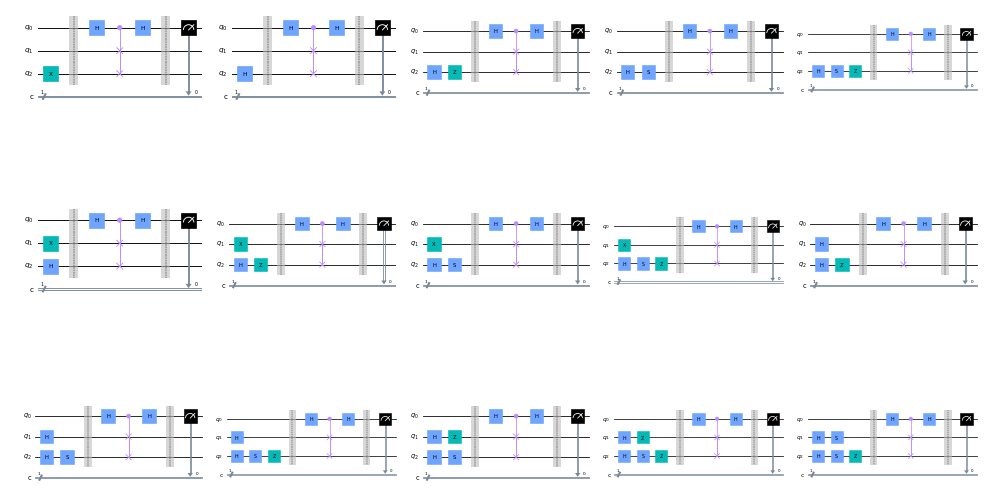

In [46]:
circuits = [qc1, qc2, qc3, qc4, qc5, qc6]
swap_test_circuits = []
for idx, qc_a in enumerate(circuits[:-1]):
    for qc_b in circuits[idx + 1 :]:
        swap_test_circuits.append(swap_test(qc_a, qc_b))
draw_circuits(swap_test_circuits)

In [50]:
distributions, logs = toshiko_submit(swap_test_circuits)
distributions

{'RECEIVER_DEQUEUED': '2024-02-14 12:57:32.502243+00:00', 'RECEIVER_ENQUEUED': '2024-02-14 12:57:33.632373+00:00', 'RECEIVER_FROM_SCC': '2024-02-14 12:57:33.632220+00:00', 'RECEIVER_TO_SCC': '2024-02-14 12:57:32.502614+00:00', 'SERVER_DEQUEUED': '2024-02-14 12:57:33.639225+00:00', 'SERVER_ENQUEUED': '2024-02-14 12:57:16.914896+00:00', 'SERVER_RECEIVED': '2024-02-14 12:57:16.660189+00:00'}


[{'0': 501, '1': 499},
 {'0': 541, '1': 459},
 {'0': 568, '1': 432},
 {'0': 566, '1': 434},
 {'0': 540, '1': 460},
 {'0': 419, '1': 581},
 {'0': 443, '1': 557},
 {'0': 426, '1': 574},
 {'0': 506, '1': 494},
 {'0': 521, '1': 479},
 {'0': 471, '1': 529},
 {'0': 517, '1': 483},
 {'0': 516, '1': 484},
 {'0': 502, '1': 498},
 {'0': 445, '1': 555}]

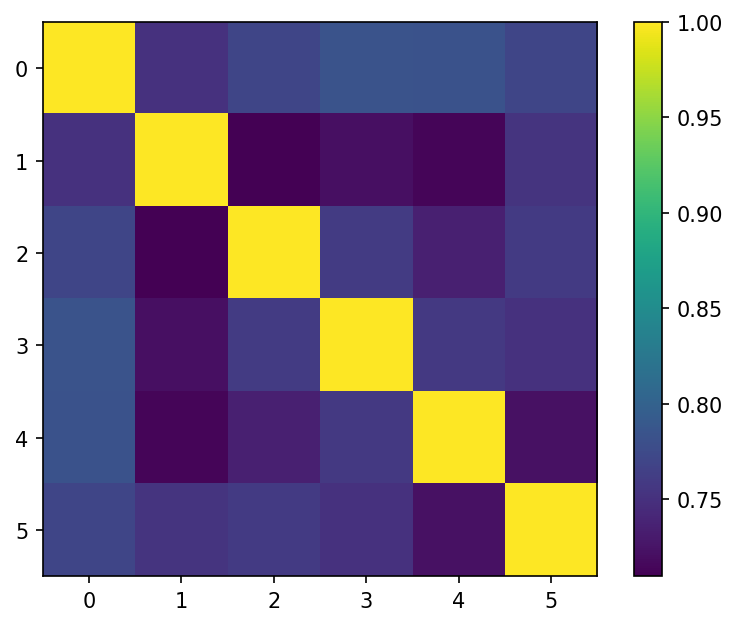

In [51]:
plot_fidelities_heatmap(distributions)

You should see a heatmap similar to the following:

<center><img src="resources/sample_heatmap.png" width="600"/></center>

Each row and column corresponds to one of your 6 states. A given entry $(i, j)$ represents the fidelity comparing states $i$ and $j$. E.g., all diagonal elements should be 1.0 because comparing two states to each other should yield a fidelity of 1.0 (they are identical).

# <font color="green">**Congratulations! This concludes the DCM3 Quantum Challenge.**</font>